<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/425_hierarchical_models.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(hier_beta_binom_model)=
# Modello gerarchico beta-binomiale

In questo capitolo, introdurremo il concetto di modelli gerarchici bayesiani attraverso l'impiego del modello beta-binomiale. Tale modello è utilizzato per l'analisi di dati binomiali che emergono da unità di osservazione multiple, come individui, gruppi o categorie, organizzate in una struttura gerarchica. 

Tradizionalmente, i dati binomiali sono modellati attraverso la distribuzione binomiale, che quantifica il numero di "successi" in un numero fisso di tentativi indipendenti, ognuno con una probabilità $ p $ di successo. Tuttavia, quando si affrontano dati stratificati o raggruppati, l'assunzione di una singola $ p $ potrebbe non essere appropriata. Il modello beta-binomiale interviene in questa situazione, introducendo un livello gerarchico superiore.

Nel modello gerarchico beta-binomiale, ogni gruppo ha una sua probabilità $ p $ di successo, e queste probabilità sono a loro volta generate da una distribuzione beta con parametri $ \alpha $ e $ \beta $. Questo consente di modellare la variabilità sia all'interno che tra i gruppi, mentre si condividono le informazioni tra essi per ottenere stime più robuste.

Matematicamente, il modello si può esprimere come segue:

$$
\begin{aligned}
y_i &\sim \text{Binomial}(n_i, p_i), \quad i = 1, \ldots, k, \\
p_i &\sim \text{Beta}(\alpha, \beta), \quad i = 1, \ldots, k, \\
\alpha, \beta &\sim \text{Prior distributions}.
\end{aligned}
$$

In questo quadro, $ y_i $ rappresenta il numero di successi nel gruppo $ i $, $ n_i $ è il numero di tentativi nel gruppo $ i $, e $ k $ è il numero totale di gruppi. I parametri $ \alpha $ e $ \beta $ della distribuzione beta sono spesso oggetto di inferenza bayesiana e possono avere distribuzioni a priori associate.

L'approccio gerarchico migliora l'efficienza statistica dell'inferenza, permettendo una stima più accurata dei parametri del modello a livello sia del gruppo che della popolazione. Inoltre, fornisce un quadro per comprendere la variabilità intragruppo e intergruppo in termini di una struttura di parametri comuni e specifici del gruppo.

Nel corso di questo capitolo, applicheremo il modello gerarchico beta-binomiale a un set di dati reali e discuteremo le metodologie per l'inferenza bayesiana e l'interpretazione dei risultati.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import arviz as az
import requests
from io import StringIO
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## Analisi bayesiana della "terapia tattile" 

Esaminiamo un problema presentato nel lavoro di {cite:t}`doing_bayesian_data_an` riguardante la "terapia tattile" (Therapeutic Touch), una pratica infermieristica incentrata sulla manipolazione del presunto "campo energetico" di un paziente. Nonostante la sua prevalenza nelle scuole di infermieristica e negli ospedali negli Stati Uniti, come riportato da {cite:t}`rosa1998close`, evidenze empiriche a supporto della sua efficacia sono scarse o assenti.

Il focus dell'indagine di {cite:t}`rosa1998close` è una delle asserzioni cardine degli operatori di terapia tattile: la presunta capacità di percepire i campi energetici senza contatto visivo. Per testare questa affermazione, è stato progettato un esperimento in cui gli operatori ponevano le loro mani attraverso un pannello che bloccava la visione. In ciascuna prova, un esaminatore, seguendo l'esito di un lancio di moneta, posizionava la sua mano sopra una delle mani dell'operatore. L'operatore doveva quindi identificare quale delle sue mani era stata "selezionata" dall'esaminatore. Ogni tentativo è stato classificato come "corretto" o "errato".

L'unità di osservazione in questo esperimento è costituita da un set di 10 prove per operatore. In totale, lo studio ha coinvolto 21 operatori, con sette di loro sottoposti a retest dopo circa un anno. I dati di retest sono stati trattati come entità indipendenti, portando a un campione effettivo di 28 osservazioni. La metrica di interesse è la proporzione di risposte corrette per ciascun operatore, con una proporzione attesa di 0.50 sotto l'ipotesi nulla di performance casuale.

La domanda della ricerca centrale è se il campione nel suo complesso è in grado di ottenere una prestazione superiore a quella attesa in base al caso soltanto e, inoltre, se vi sono variazioni  nelle prestazioni individuali.

Inizieremo importando i dati forniti da {cite:t}`doing_bayesian_data_an`.

In [3]:
# Define the URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/boboppie/kruschke-doing_bayesian_data_analysis/master/2e/TherapeuticTouchData.csv"
# Download the content of the CSV file
response = requests.get(url)
tt_dat = pd.read_csv(StringIO(response.text))
print(tt_dat.head())

   y    s
0  1  S01
1  0  S01
2  0  S01
3  0  S01
4  0  S01


In [4]:
tt_dat.shape

(280, 2)

Nella colonna `y`, il valore 1 indica una risposta corretta, mentre 0 indica una risposta errata. La seconda colonna contiene il codice identificativo di ciascun operatore.

Calcoliamo la proporzione di risposte corrette per ciascun operatore.

In [5]:
tt_agg = tt_dat.groupby("s").agg(proportion_correct=("y", "mean")).reset_index()
tt_agg

,s,proportion_correct
0,S01,0.1
1,S02,0.2
2,S03,0.3
3,S04,0.3
4,S05,0.3
5,S06,0.3
6,S07,0.3
7,S08,0.3
8,S09,0.3
9,S10,0.3


Creiamo ora un istogramma che rappresenti le proporzioni di risposte corrette. Valori superiori a 0.5 indicano la capacità di discriminare correttamente la posizione della mano dell'esaminatore, anche senza vederla. Valori inferiori a 0.5 indicano invece che, sebbene si riesca a distinguere la posizione della mano dell'esaminatore, le risposte sbagliate sono più frequenti rispetto al caso.

La distribuzione è unimodale, con un intervallo di valori tra 0 e 1, quindi può essere adeguatamente descritta dalla densità Beta.

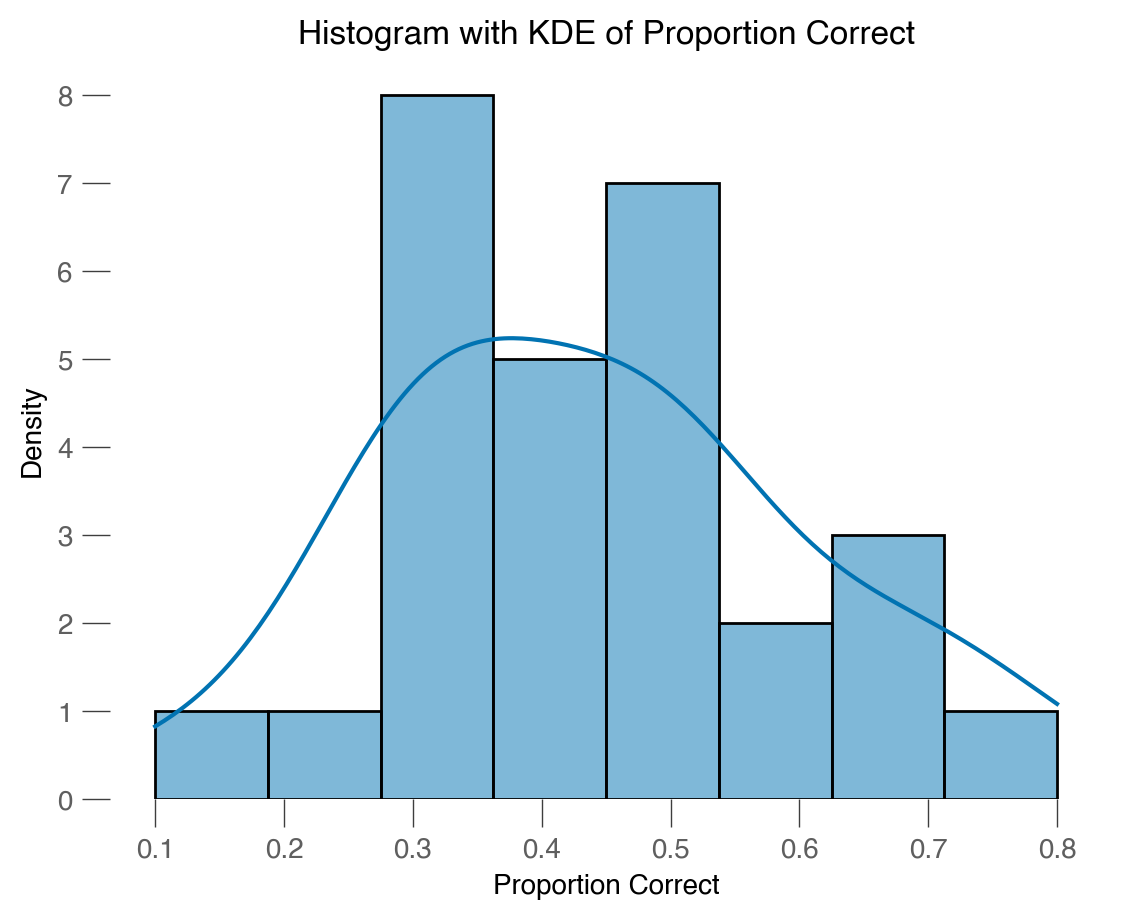

In [6]:
sns.histplot(data=tt_agg, x="proportion_correct", bins=8, kde=True)
plt.xlabel("Proportion Correct")
plt.ylabel("Density")
plt.title("Histogram with KDE of Proportion Correct")
plt.show()

Se consideriamo il numero di risposte corrette come "successi", il modello di campionamento binomiale risulta essere una scelta naturale per questi dati. Osservando le proporzioni di risposte corrette, notiamo che alcuni operatori hanno tassi di risposte corrette molto più elevati rispetto ad altri. Ad esempio, la proporzione più alta di risposte corrette è 0.8 e la più bassa è 0.1. Se si assumesse una probabilità comune $p$ di risposte corrette per tutti i 28 operatori, tale modello non renderebbe conto dei dati in maniera adeguata. D'altra parte, se si creassero 28 modelli di campionamento binomiale separati, uno per ciascun operatore, e si effettuassero inferenze separate, si perderebbe la possibilità di utilizzare informazioni potenziali sul tasso di risposte corrette dell'operatore $j$ quando si conducono inferenze riguardanti un altro operatore $i$. 

Il modello gerarchico rappresenta una via di mezzo tra l'approccio combinato e quello separato nella modellazione. Costruiamo il modello gerarchico partendo dall'assunzione che il numero di risposte corrette per ciascun operatore sia una variabile casuale Binomiale. Per ciascuno dei ventotto operatori possiamo dunque scrivere:

$$
y_i \sim Binomial(n_i, p_i),
$$

con $i = 0, \dots, 27$.

Quale distribuzione a priori per il parametro sconosciuto $p_i$ possiamo fissare una distribuzione Beta di parametri $a$ e $b$:

$$
p_i \sim Beta(a, b).
$$

Va notato che, in questo modo, gli iperparametri $a$ e $b$ sono condivisi tra tutti gli operatori. Se $a$ e $b$ sono noti, allora la distribuzione a posteriori per il parametro $p$ è una distribuzione Beta:

$$
p_i \mid y_i \sim Beta(a + y_i, b + n_i - y_i). 
$$

Nel caso generale in cui gli iperparametri $a$ e $b$ sono incogniti, è necessario fissare una distribuzione a priori per ciascuno di essi. 

Applichiamo dunque il modello gerarchico descritto sopra ai dati del *therapeutic touch*. Iniziamo a calcolare il numero di risposte corrette di ciascun operatore.

In [7]:
result = tt_dat.groupby("s")["y"].sum().reset_index()
y = result["y"]
print(*y)

1 2 3 3 3 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 5 5 6 6 7 7 7 8


In media, gli operatori rispondono correttamente 4.39 volte su 10.

In [8]:
y.mean()

4.392857142857143

Creiamo inoltre il vettore `N` che fornisce il numero di prove per ciascun operatore.

In [9]:
N = tt_dat.groupby("s")["y"].count() 
N

s
S01    10
S02    10
S03    10
S04    10
S05    10
S06    10
S07    10
S08    10
S09    10
S10    10
S11    10
S12    10
S13    10
S14    10
S15    10
S16    10
S17    10
S18    10
S19    10
S20    10
S21    10
S22    10
S23    10
S24    10
S25    10
S26    10
S27    10
S28    10
Name: y, dtype: int64

Esaminiamo dunque i dati a disposizione.

In [10]:
print(*N)

10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10


In [11]:
print(*y)

1 2 3 3 3 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 5 5 6 6 7 7 7 8


Definiamo le coordinate necessarie per specificare la forma delle diverse distribuzioni di densità.

In [13]:
# The data has one dimension: operators_idx
# The "coordinates" are the unique values that this dimension can take
COORDS = {
    "operators_idx": np.arange(len(y)),
}

print(COORDS)

{'operators_idx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])}


Scriviamo ora il modello gerarchico Beta-Binomiale con la sintassi PyMC.

In [14]:
with pm.Model(coords=COORDS) as model:
    y_data = pm.ConstantData("y_data", y)
    n_trials = pm.ConstantData("n_trials", N)
    alpha = pm.Gamma("alpha", 8, 2)
    beta = pm.Gamma("beta", 27, 5)
    p = pm.Beta("p", alpha, beta, dims="operators_idx")
    Y_obs = pm.Binomial("Y_obs", n=n_trials, p=p, observed=y_data, dims="operators_idx")

Il modello Bayesiano definito sopra è progettato per analizzare i dati provenienti da diversi operatori nel contesto di un esperimento binomiale. Il termine "binomiale" implica che ci sono solo due possibili esiti per ciascun tentativo: successo o insuccesso. Il modello utilizza una struttura gerarchica, dove la distribuzione Beta viene utilizzata per modellare la probabilità di successo degli operatori, e la distribuzione Gamma serve come distribuzione a priori per i parametri di forma della distribuzione Beta.

1. **Alpha e beta (parametri di forma della distribuzione Beta):** 
    - Questi sono i parametri che governano la forma della distribuzione Beta per la variabile latente `p`.
    - Sono modellati come variabili casuali che seguono una distribuzione Gamma. In questo specifico modello, `alpha` segue una distribuzione Gamma con parametri 8 e 2, mentre `beta` segue una distribuzione Gamma con parametri 27 e 5.
  
2. **p (probabilità di successo):** 
    - Questa è la variabile latente di interesse e rappresenta la probabilità di successo in un esperimento binomiale.
    - Segue una distribuzione Beta parametrizzata da `alpha` e `beta`.

3. **Y_obs (variabile osservata):** 
    - Rappresenta il numero di successi ottenuti in `N` tentativi per ciascun operatore.
    - Segue una distribuzione binomiale con `N` come numero di tentativi e `p` come probabilità di successo.

- Il modello utilizza la chiave `dims` per specificare che sia la variabile latente `p` che la variabile osservata `Y_obs` hanno una dimensione etichettata come `operators_idx`.
- Questa etichetta di dimensione è associata a un dizionario Python `COORDS` che contiene 28 valori distinti, rappresentando così 28 operatori differenti. 

Il modello stima probabilità di successo separate (`p`) per ciascun operatore, permettendo così di catturare l'eterogeneità tra diverse unità di osservazione.

Le distribuzioni a priori per `alpha` e `beta` sono scelte sulla base di informazioni empiriche. Ad esempio, se la probabilità di successo media è 0.44, i parametri della distribuzione Beta che producono questa media sono approssimativamente $\alpha = 4$ e $\beta = 5.4$. 
I parametri delle distribuzioni Gamma per `alpha` e `beta` sono quindi scelti in modo da centrarsi attorno a queste stime empiriche, dando così una priorità informativa ai parametri.

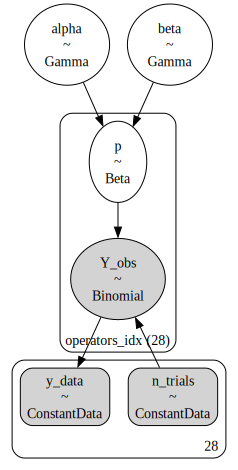

In [15]:
pm.model_to_graphviz(model)

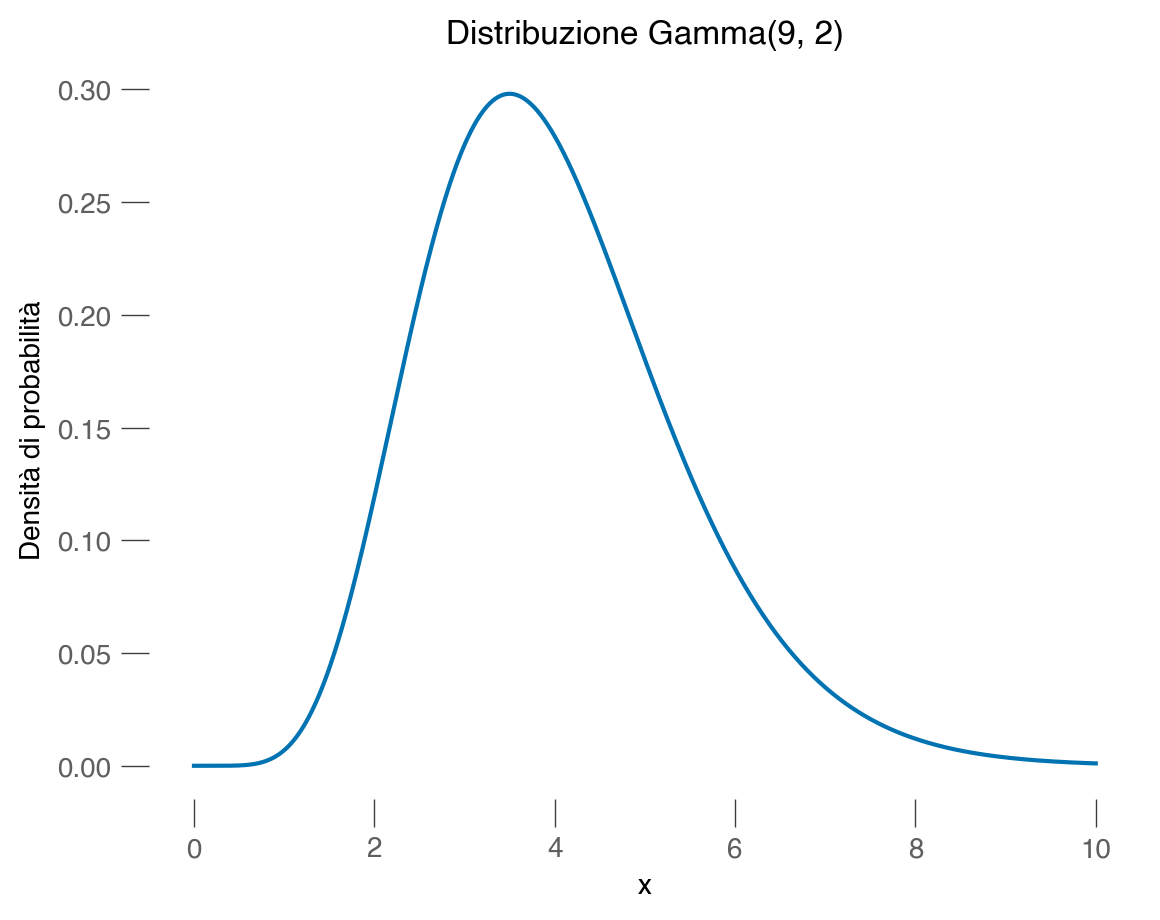

In [16]:
a = 8
b = 2

x = np.linspace(0, 10, 1000)  # Valori x da 0 a 10
yy = stats.gamma.pdf(x, a, scale=1/b)  # Funzione di densità di probabilità Gamma

plt.plot(x, yy)
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.title('Distribuzione Gamma(9, 2)');
plt.show()

Eseguiamo ora il campionamento.

In [17]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts(2000, tune=1000)

Compiling...
Compilation time =  0:00:02.700646
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 0:   0%|          | 0/3000 [00:04<?, ?it/s]



Running chain 3: 100%|██████████| 3000/3000 [00:04<00:00, 609.56it/s]  


Sampling time =  0:00:05.543261
Transforming variables...
Transformation time =  0:00:00.058316


Nel modello beta-binomiale gerarchico, tutte le probabilità di successo dei diversi operatori vengono modellate utilizzando la stessa distribuzione a priori. Questo significa che si assume che le probabilità di successo di ciascun operatore derivino da una distribuzione comune. Di conseguenza, le stime individuali delle probabilità di successo per ogni operatore saranno "shrunk" o "ritratte" verso il valore medio della distribuzione comune. Questo fenomeno è noto come "shrinkage". In altre parole, le stime tendono ad avvicinarsi alla media del gruppo, piuttosto che essere stime completamente indipendenti. Questo effetto di "shrinkage" permette di ottenere stime più stabili e generalizzabili, soprattutto quando i campioni per alcuni operatori sono limitati o poco informativi.

Questo effetto di shrinkage ha un importante vantaggio: migliora la precisione delle stime individuali. Le stime aggregate attraverso l'informazione del gruppo possono essere più affidabili e robuste rispetto alle stime basate su un numero limitato di dati. Di conseguenza, il modello beta-binomiale gerarchico permette di ottenere stime più accurate e stabili per le probabilità di successo degli operatori, tenendo conto sia delle informazioni specifiche di ogni operatore che delle informazioni comuni a tutto il gruppo -- si confrontino le stime a posteriori della probabilità di successo `xs` con le stime della probabilità di successo calcolate separatamente per ciascun operatore (si veda la tabella precedente).

Esaminiamo dunque le stime a posteriori della probabilità di successo di ciascun operatore.

In [18]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.57,0.86,3.06,6.28,0.01,0.01,6150.57,5481.98,1.0
beta,5.76,0.92,4.14,7.55,0.01,0.01,6899.60,6463.74,1.0
p[0],0.27,0.10,0.09,0.45,0.00,0.00,10217.15,6501.05,1.0
p[1],0.32,0.11,0.12,0.52,0.00,0.00,11245.19,5439.09,1.0
p[2],0.37,0.11,0.17,0.57,0.00,0.00,11293.23,5526.59,1.0
p[3],0.37,0.11,0.18,0.57,0.00,0.00,10811.50,5384.79,1.0
p[4],0.37,0.11,0.18,0.58,0.00,0.00,12464.97,5882.40,1.0
p[5],0.37,0.10,0.17,0.57,0.00,0.00,12535.30,6427.29,1.0
p[6],0.37,0.11,0.18,0.58,0.00,0.00,11332.10,5715.46,1.0
p[7],0.37,0.11,0.18,0.57,0.00,0.00,11047.58,5681.99,1.0


Creiamo un array che contiene le stime bayesiane della probabilità di successo di ciascun operatore fornite sopra dalla funzione `summary` di ArviZ. Per fare questo usiamo le funzionalità di `xarray`.

In [19]:
# Bayesian estimates 
# Calcola la media lungo le dimensioni 'chain' e 'draw'
bayesian_estimates = trace.posterior["p"].mean(dim=("chain", "draw"))
print(bayesian_estimates.values)

[0.27269006 0.32243759 0.37251425 0.37129349 0.37117976 0.37085613
 0.37099244 0.37244973 0.37152175 0.36992649 0.42102667 0.42107158
 0.42197513 0.42076767 0.42093558 0.4714561  0.47264891 0.47178116
 0.47039495 0.47077494 0.47211747 0.47027429 0.52033201 0.52028996
 0.57033829 0.57038627 0.57002266 0.61800148]


Generiamo un array con le probabilità empiriche.

In [20]:
# Empirical probabilities
empirical_probs = y.values / N.values 
print(empirical_probs)

[0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.6 0.6 0.7 0.7 0.7 0.8]


Il grafico seguente confronta le probabilità empiriche con le stime Bayesiane per la probabilità di successo associata a ciascun operatore. Questa rappresentazione evidenzia il fenomeno di "shrinkage" intrinseco ai modelli Bayesiani gerarchici. In particolare, il grafico illustra come le stime Bayesiane delle probabilità di successo per gli operatori tendano a convergere verso la media generale, in confronto alle probabilità empiriche. 

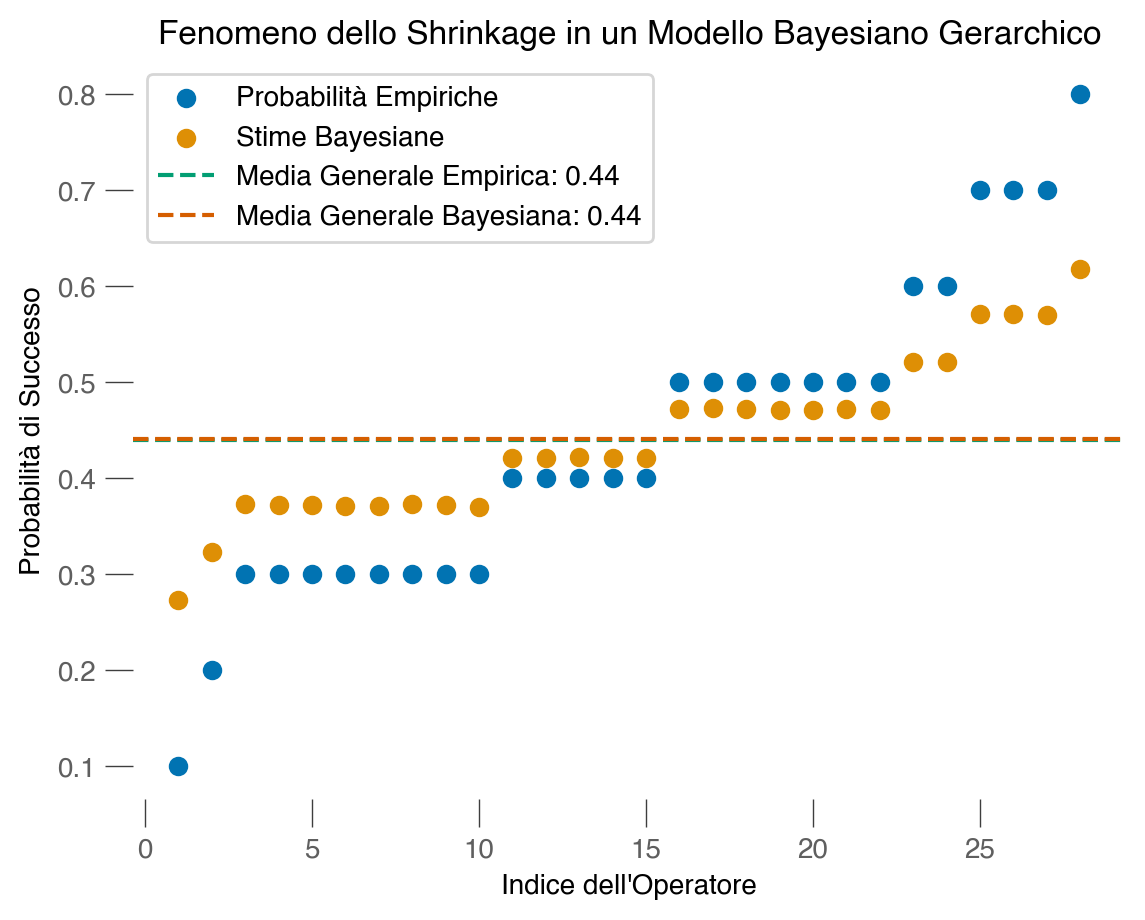

In [21]:
# Calcola la media generale delle probabilità empiriche
mean_empirical_prob = np.mean(empirical_probs)

# Calcola la media generale delle stime Bayesiane
mean_bayesian_estimate = np.mean(bayesian_estimates)

# Crea il grafico
plt.figure()

# Traccia le probabilità empiriche
plt.scatter(range(1, 29), empirical_probs, color='C0', label='Probabilità Empiriche')

# Traccia le stime Bayesiane
plt.scatter(range(1, 29), bayesian_estimates, color='C1', label='Stime Bayesiane')

# Aggiungi linee orizzontali per indicare le medie generali
plt.axhline(y=mean_empirical_prob, color='C2', linestyle='--', label=f'Media Generale Empirica: {mean_empirical_prob:.2f}')
plt.axhline(y=mean_bayesian_estimate, color='C3', linestyle='--', label=f'Media Generale Bayesiana: {mean_bayesian_estimate:.2f}')

# Etichette e titolo
plt.xlabel('Indice dell\'Operatore')
plt.ylabel('Probabilità di Successo')
plt.title('Fenomeno dello Shrinkage in un Modello Bayesiano Gerarchico')
plt.legend()

# Mostra il grafico
plt.show()

Nella figura seguente, le stime bayesiane sono rappresentate mediante un "forest plot" del parametro `p`, insieme all'intervallo di credibilità Highest Density Interval (HDI) al 94%.

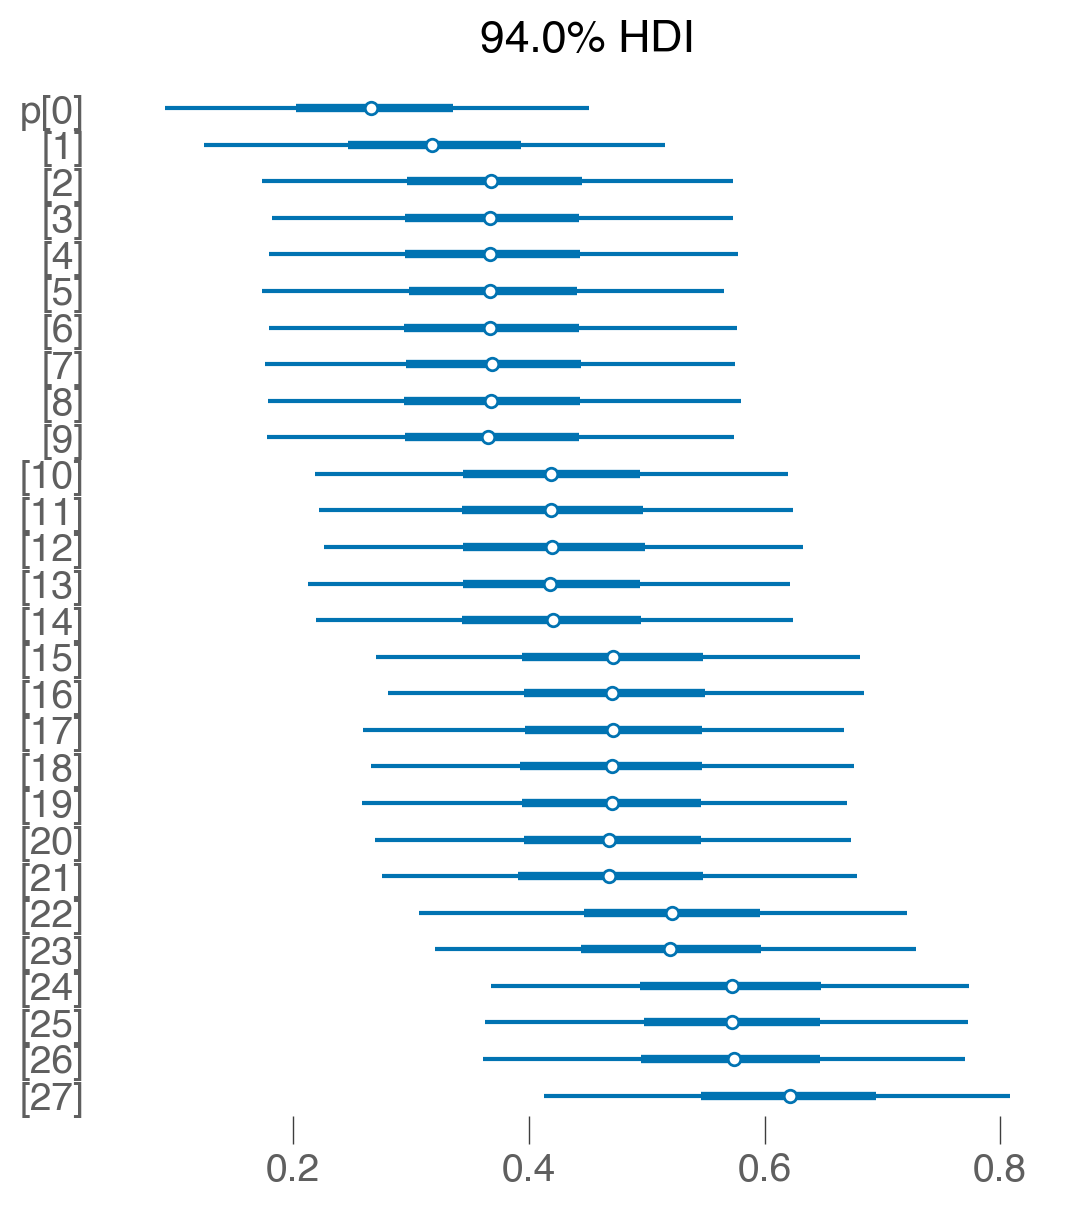

In [22]:
samples_p = trace.posterior["p"]
az.plot_forest(samples_p, combined=True, hdi_prob=0.94)
plt.show()

Esaminiamo la distribuzione a posteriori dei parametri `alpha` e `beta`.

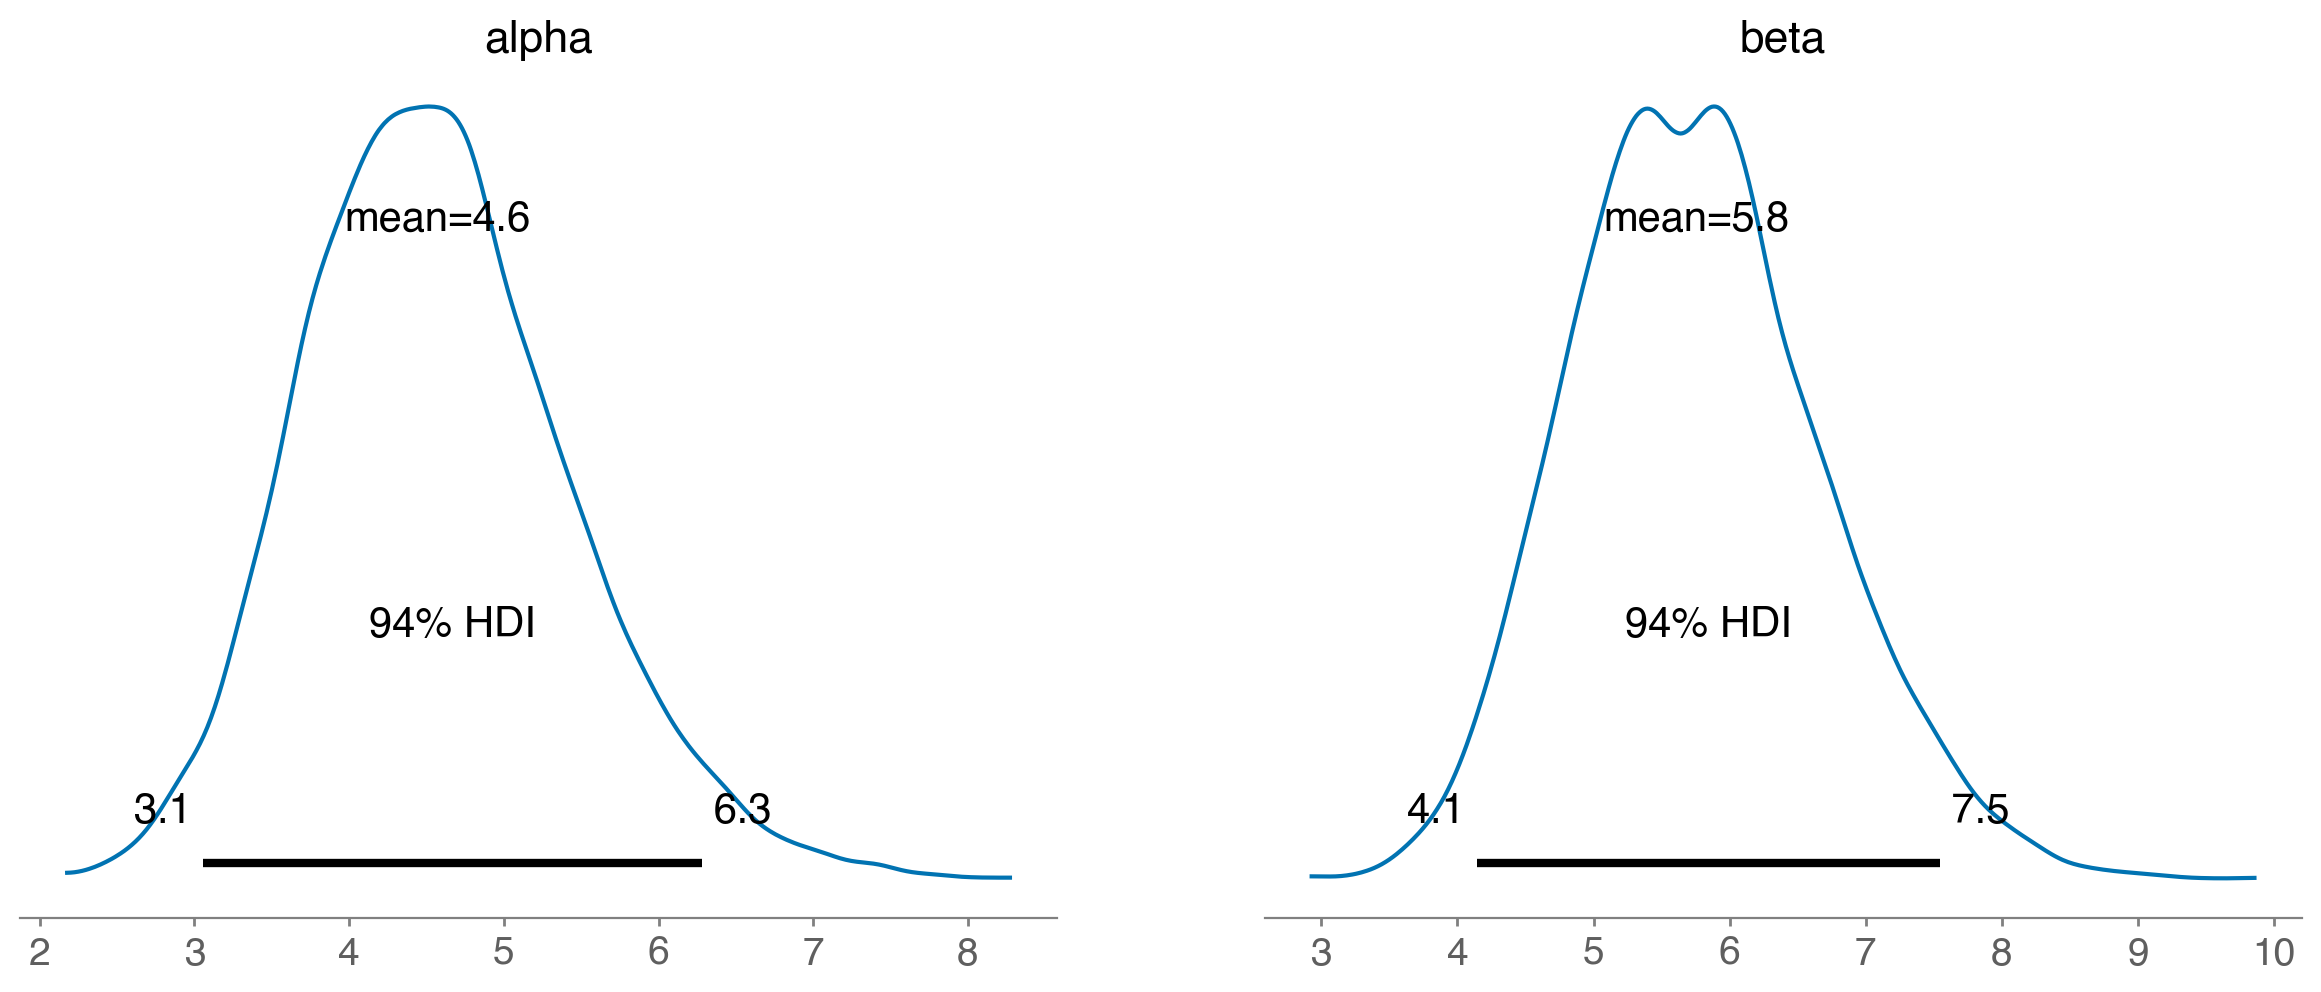

In [23]:
az.plot_posterior(trace, var_names=["alpha", "beta"])
plt.show()

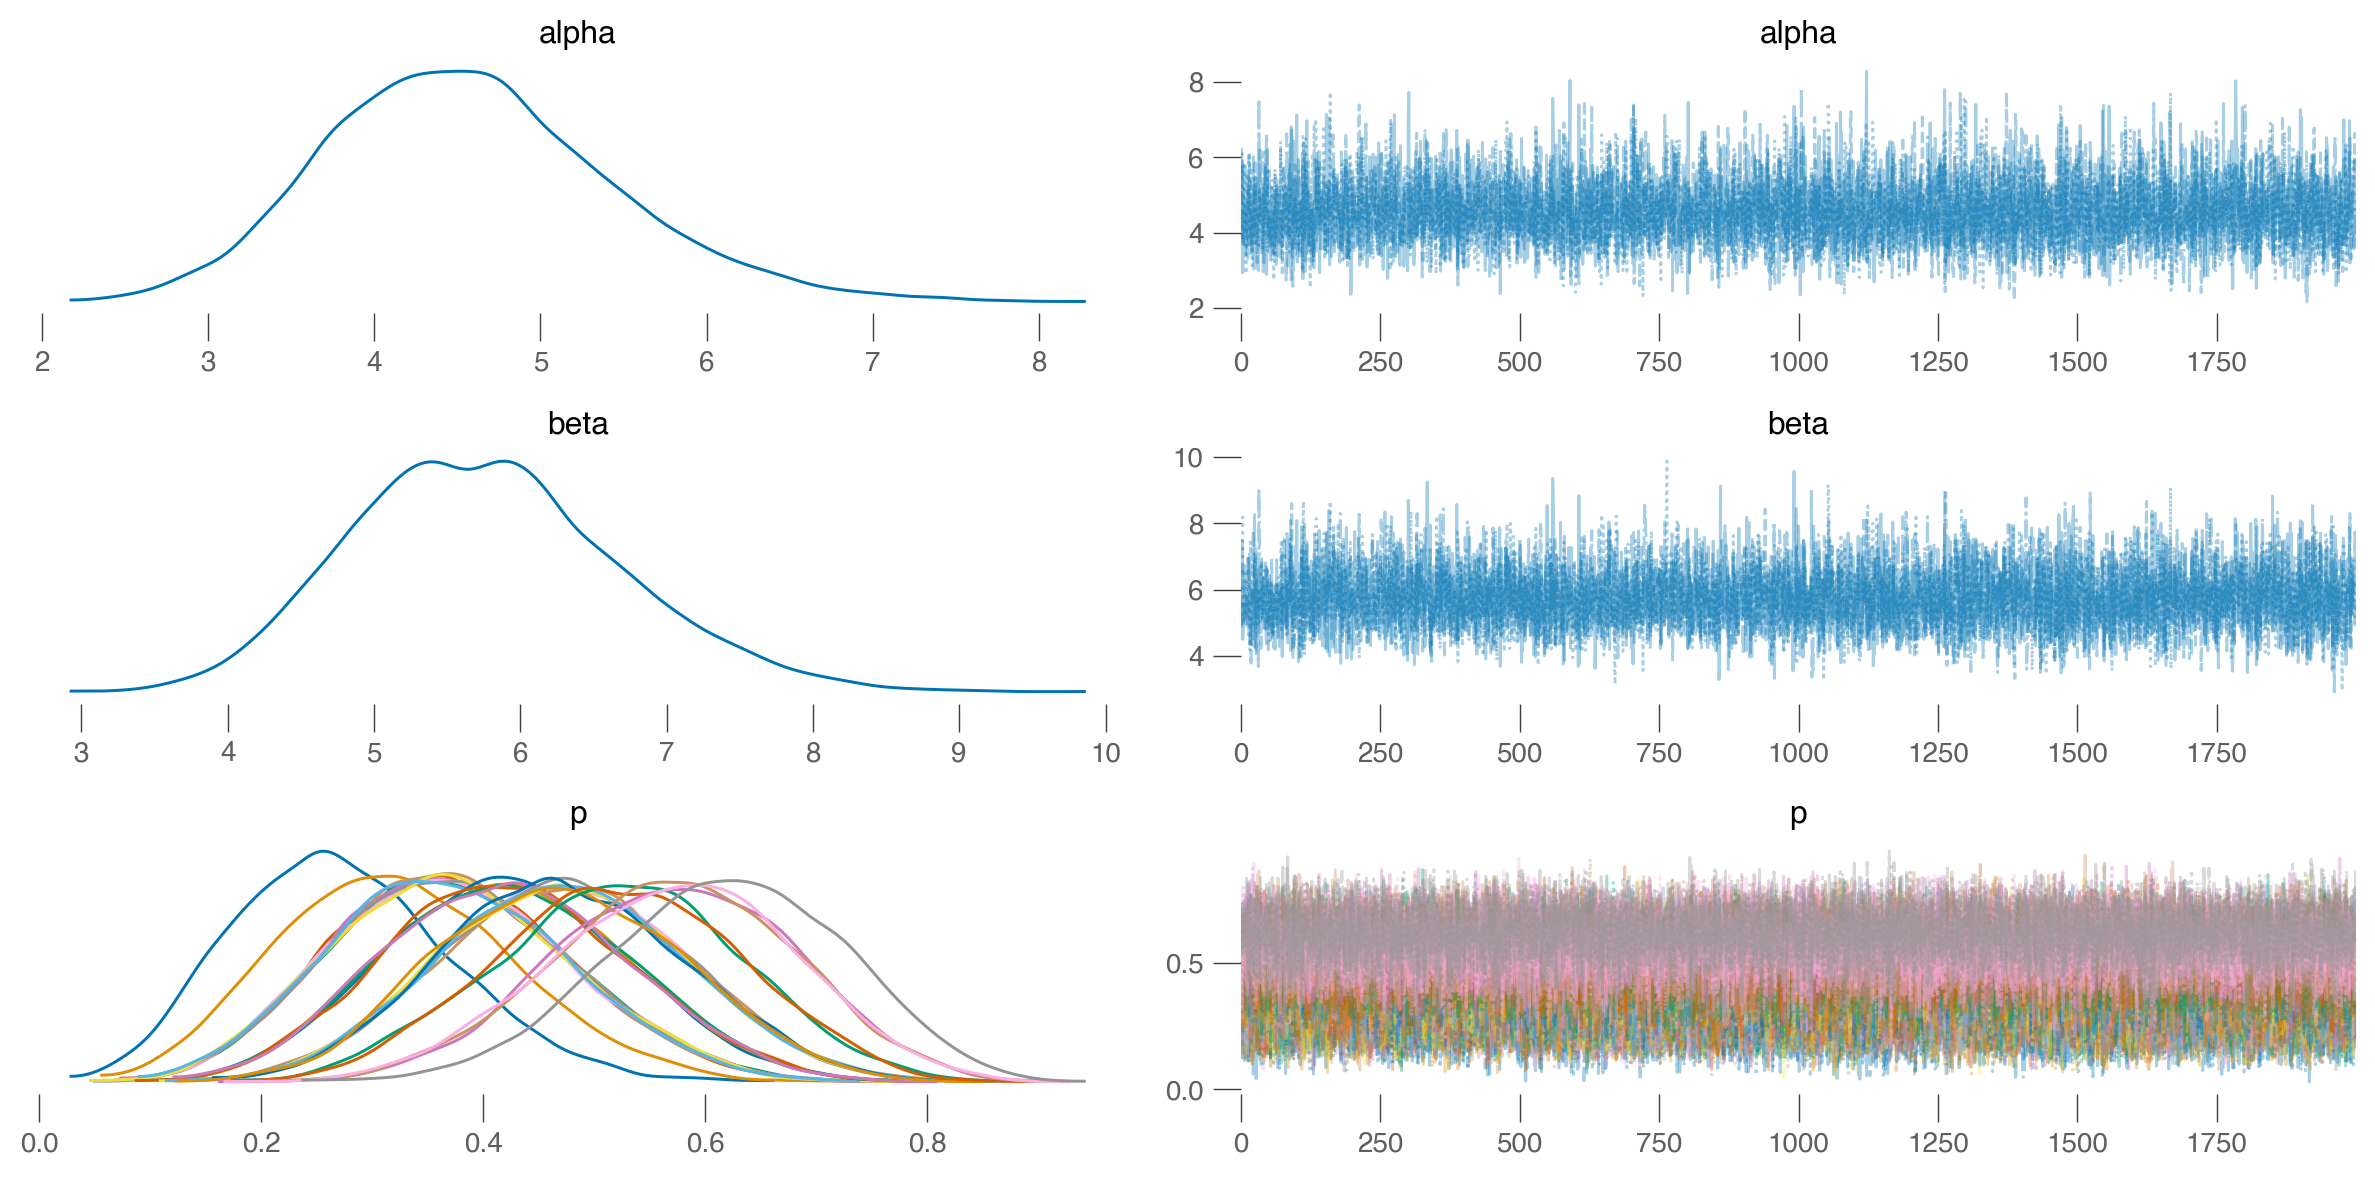

In [24]:
az.plot_trace(trace, combined=True)
plt.tight_layout()
plt.show()

Le distribuzioni posteriori degli iperparametri, prese da sole, non hanno un significato chiaro. Tuttavia, possiamo utilizzarle per calcolare la distribuzione a posteriori della probabilità di una risposta corretta per tutto il gruppo.

Iniziamo a recuperare le stime a posteriori di  `alpha` e `beta`.

In [25]:
alphas = trace.posterior["alpha"]
betas = trace.posterior["beta"]

print(alphas)

<xarray.DataArray 'alpha' (chain: 4, draw: 2000)>
array([[4.40560187, 6.2164827 , 5.45923304, ..., 5.96735035, 3.62421606,
        4.7887031 ],
       [5.66947369, 3.81802829, 3.96252257, ..., 4.95704574, 4.57719779,
        4.55818958],
       [4.82753473, 5.76767101, 4.15193981, ..., 6.13605517, 6.63470151,
        5.86129976],
       [3.76933875, 3.77847762, 6.09520619, ..., 3.94178857, 4.33886192,
        4.65218387]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999


Dato che ciascuna coppia di parametri  `alpha` e `beta` definisce la distribuzione a posteriori Beta, calcoliamo la media della distribuzione Beta definita da ciascuna coppia di valori `alpha` e `beta`. 

In [26]:
# Function to calculate the mean of a Beta distribution
def beta_mean(alpha, beta):
    return alpha / (alpha + beta)

# Calculate the means for each pair of alpha and beta
sample_posterior_x_means = np.array([beta_mean(a, b) for a, b in zip(alphas, betas)])

Ci sono 8000 di queste medie.

In [27]:
sample_posterior_x_means.shape

(4, 2000)

In [28]:
sample_posterior_x_means

array([[0.39807708, 0.5368076 , 0.42194566, ..., 0.54275568, 0.40133269,
        0.47322456],
       [0.49538367, 0.39457214, 0.39347674, ..., 0.45943208, 0.48567061,
        0.46566607],
       [0.45396018, 0.54029601, 0.42487946, ..., 0.4839771 , 0.46186557,
        0.48728093],
       [0.40967233, 0.43774724, 0.52223302, ..., 0.39167441, 0.41604434,
        0.46390271]])

In [29]:
print(sample_posterior_x_means.mean())

0.44181595682091823


Con questi 8000 valori a posteriori della media della distribuzione Beta che rappresenta il "meccanismo generatore" da cui i valori `p` di ciascun operatore vengono tratti, generiamo una densità empirica da cui è anche possibile calcolare l'intervallo che contiene il 94% dei valori della distribuzione.

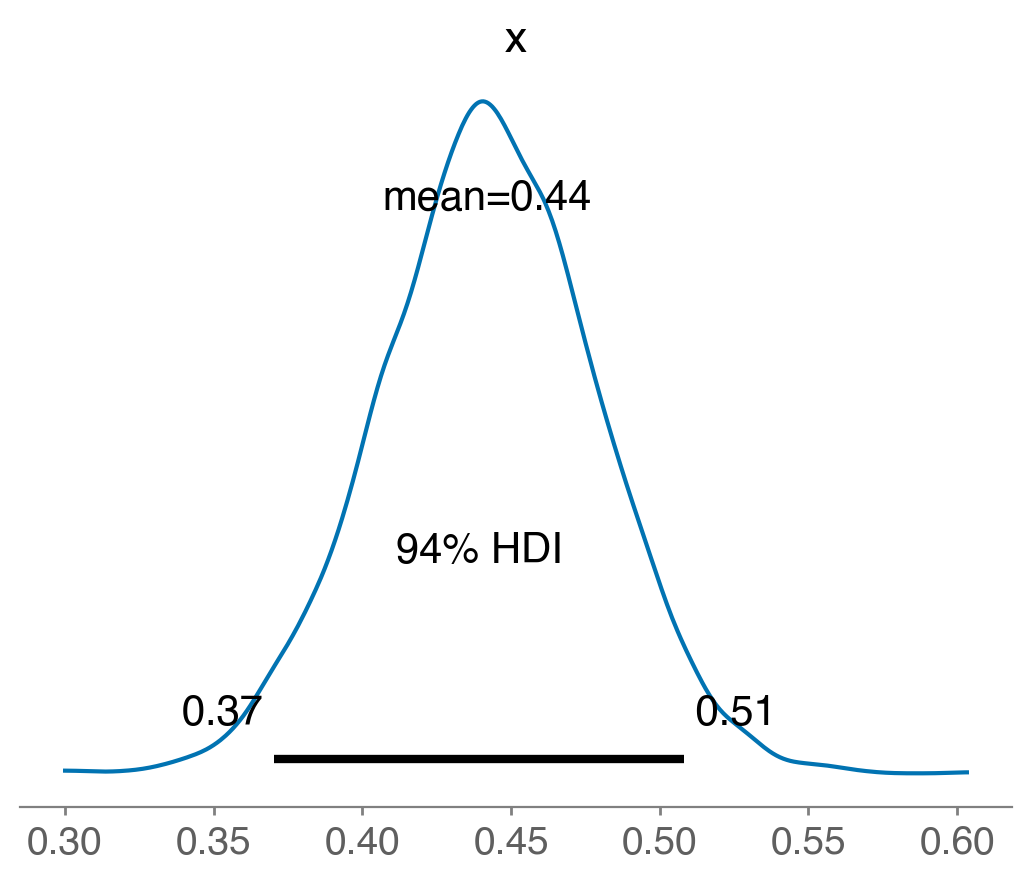

In [30]:
az.plot_posterior(sample_posterior_x_means)
plt.show()

L'intervallo [0.37, 0.51] rappresenta l'intervallo di credibilità al 94% per la probabilità di risposta corretta `p`, considerando l'insieme del gruppo degli operatori. Questo intervallo ci fornisce un'indicazione sulla variabilità delle probabilità di successo tra gli operatori, considerando sia le differenze tra di loro che le somiglianze all'interno del gruppo.

Poiché l'intervallo di credibilità include il valore 0.5, possiamo concludere che non ci sono evidenze credibili che gli operatori, considerati nel loro insieme, siano in grado di "percepire il campo energetico di una persona senza vedere le mani" ad un livello diverso rispetto a quello che ci si potrebbe aspettare dal caso soltanto. 

## Considerazioni conclusive

Il modello gerarchico beta-binomiale rappresenta uno strumento fondamentale per l'analisi di dati binomiali provenienti da gruppi o categorie diverse, consentendo di trattare dati complessi in modo integrato. Questo modello ci permette di studiare le probabilità di successo in modo unificato, considerando sia le caratteristiche specifiche di ogni gruppo che le somiglianze tra di essi. L'approccio gerarchico aumenta la precisione delle stime e ci aiuta a comprendere meglio le differenze tra i gruppi e le tendenze comuni a tutti. Questo rende il modello gerarchico beta-binomiale uno strumento importante per la valutazione e l'interpretazione di dati binomiali raggruppati.

## Watermark

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Aug 29 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

pytensor: 2.14.2

numpy     : 1.25.2
matplotlib: 3.7.2
arviz     : 0.16.1
pymc      : 5.7.2
scipy     : 1.11.2
requests  : 2.31.0
pandas    : 2.0.3
seaborn   : 0.12.2

Watermark: 2.4.3

